# Entrenamiento de MNIST con PyTorch & Elastic Inference

Este notebook, y el codigo para esta clase esta basado en los repositorios oficiales de AWS. Si deseas revisar mas ejemplos, porfavor visita:   
https://github.com/aws/amazon-sagemaker-examples

## Contents

1. [Preliminares](#Preliminares)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Preliminares

MNIST es el set de datos que utilizamos cuando aprendimos PyTorch en la clase de Aprendizaje Maquina 2. Es conocido por sel el 'Hello World' de redes neuronales. Los datos consisten de 70 mil imagenes de 28x28 pixeles, en escala de digitos. Cada imagen contiene un digito entre 0-9. En este Notebook entrenaremos una red neuronal en Amazon Sage Maker usando PyTorch, y depues la llevaremos a produccion haciendo uso del servicio de Elastic Inference, que nos permite escalar recursos al momento de evaluar nuestros modelos, pero a bajo costo.

Para mas informacion de PyTorch en SageMaker, visita [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers), y [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

---

## Setup

Let's start by creating a SageMaker session and specifying:
- Creemos un bucket de S3, y un prefijo para nombrar nuestro entrenamiento, y modelo. **El bucket debe encontrarse en la misma region que la instancia de S3**
- Necesitaremos un rol de IAM para darle acceso al entrenamiento y hosting. Asegurate de tenerlo creado.


In [ ]:
import sagemaker
from sagemaker.local import LocalSession

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-mnist'

role = sagemaker.get_execution_role()

## Data
### Descarguemos los Datos



In [ ]:
pip install torchvision==0.5.0 --no-cache-dir

In [ ]:
from torchvision import datasets, transforms

datasets.MNIST('data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))

### Subiremos los archivos a S3
Usaremos la funcion `sagemaker.Session.upload_data` para cargar nuestros datos al bucket de S3 que definimos mas arriba. El valor que nos regresa identifica el directorio donde se encuentran. 


In [ ]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('input spec (path de S3): {}'.format(inputs))

## Train
### Training script
El archivo `mnist.py` contiene el pipe/codigo necesario para entrenar y hostear nuestro modelo en SageMaker. Como tal contiene una arquitectura para nuestra red. Si deseamos modificarla lo recomendable seria hacerlo sobre se mismo archivo. Este script es proporcionado por Amazon en su documentacion, por lo que te recomendamos le des un vistazo, pues puedes reutilizarlo en tus modelos de pytorch.  
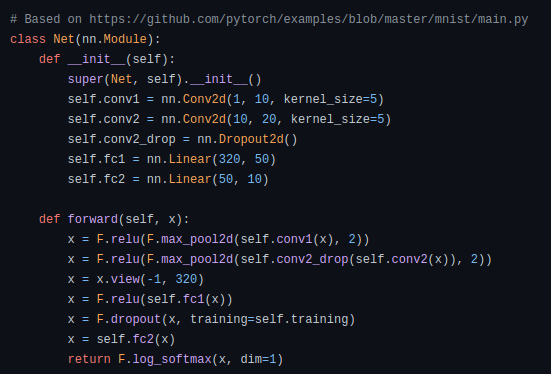



`model_fn` es la funcion que cargara nuestro modelo.  


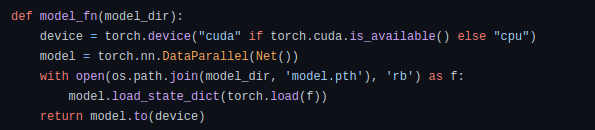


El script es muy parecido al que utilizarias si fueramos a entrenar un modelo de PyTorch fuera de SageMaker, pero con la ventaja de que podemos interactuar con sus paremetros como variables de ambiente:

* `SM_MODEL_DIR`: [string] con el path hacia el directorio donde guardaremos nuestros 'model artifacts' que son los modelos entrenados que seran hosteados mas tarde. 
* `SM_NUM_GPUS`: El numero de GPUs disponibles en nuestro contenedor.
* `SM_CURRENT_HOST`: El nombre del contenedor, y de la red.
* `SM_HOSTS`: JSON que contiene todos los hosts.

Supongamos que existe un canal de input, 'training', que se utiliza para llamar a la funcion de PyTorch `fit()`, entonces se debera seguir el siguiente formato de **sufijos** `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAINING`:  [string] que representa el directorio que contiene los datos de entrenamiento.

Para mas informacion sobre las variables de ambiente podemos visitar la documentacion oficial [SageMaker Containers](https://github.com/aws/sagemaker-containers).

Un script tipico de entrenamiento carga los datos desde los canales de input,
 configura los hyperparametros de entrenamiento, entrena el modelo, y salva el modelo en `model_dir`. Estos modelos son los que estaran siendo hosteados posteriormente.  

 
 Los hyperparametros son proporcionados a nuestro script como argumentos que, pueden ser consultados con `argparse.ArgumentParser` instance.  

 La estructura de SageMaker, y la forma en que lee nuesto codigo nos obliga a mantener una estructura particular. Por lo anterior, debemos poner nuestro codigo de entrenamiento con una guarda en el main (``if __name__=='__main__':``) de lo contrario pueden existir problemas al momento de hostear nuestro modelo (por ejemplo ejecutar el codigo de entrenamiento en vez de la prediccion).

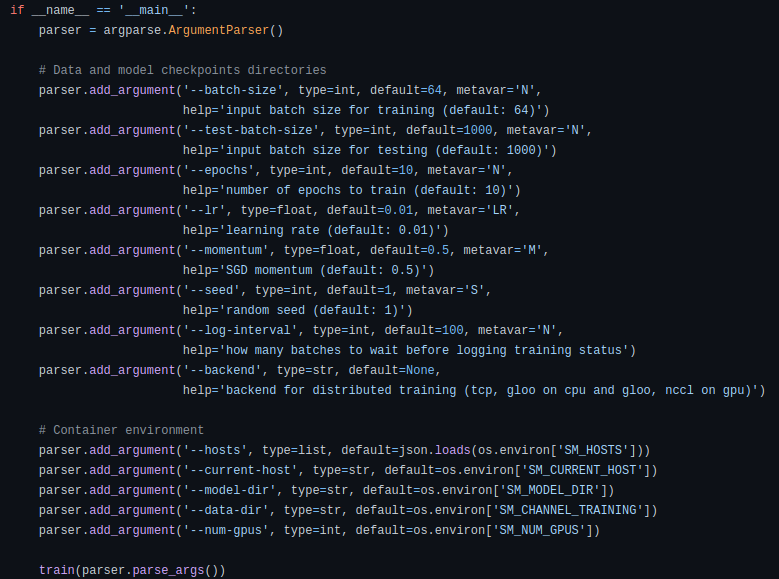

Revisemos el script con pygmentize para detectar errores en nuestro codigo:  
Documentacion https://github.com/dedalozzo/pygmentize 

In [ ]:
!pygmentize mnist.py

### Entrenamiento en SageMaker

La clase `PyTorch` de la libreria `sagemaker` nos permite ejecutar la funcion de entrenamiento como un trainig-job en la infraestructura de SageMaker.  
Para lograr esto, tenemos que configurar nuestro script de entrenamiento, asegurarnos que nuestro rol de IAM tenga los permisos necesarios, el numero de instancias de entrenamiento que utilizaremos, el tipo de instancia, y los hyperparametros.  

En este caso utilizaremos `ml.c4.xlarge`
([Lista completa de instancias](https://aws.amazon.com/sagemaker/pricing/instance-types/)).  
Los hyperparametros seran proporcionados como un dictionario que sera pasado como argumento a nuestro script de `mnist.py`.


In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='mnist.py', # script con nuestro pipeline
                    role=role,
                    framework_version='1.4.0',
                    py_version='py3',
                    train_instance_count=2,
                    train_instance_type='ml.c4.xlarge',
                    hyperparameters={
                        'epochs': 6, # epocas de entrenamiento
                        'backend': 'gloo' #backend para utilizar pytorch distribuido
                    })

Despues de construir nuestro objeto `PyTorch` con la libreria de `sagemaker` podemos entrenarlo usando los datos que se encuentran en S3. SageMaker carga los datos a nuestro sistema de archivos de la instancia automaticamente antes de empezar a entrenar.

In [ ]:
estimator.fit({'training': inputs})

In [ ]:
estimator.model_data

## Host
### Crear endpoint
Despues de entrenar nuestro modelo, debemos crear un objeto `PyTorchPredictor` que sera nuestro modelo en produccion. Este objeto crea un endpoint en SageMaker, independiente de nuestra instancia de entrenamientoq ue utilizamos anteriormente. Este endpoint nos permitira realizar inferencia en tiempo real con nuestro modelo ya entrenado.  

Como mencionamos anteriormente, la funcion `model_fn` en el script `mnist.py` es necesaria para cargar nuestro modelo. Usaremos la implementacion por default de las funciones `input_fn`, `predict_fn`, `output_fn` y `transform_fm` definidas en la documentacion de [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).  

Los argumentos que recibira nuestro metodo de `deploy` son el numero de instancias iniciales, y el tipo de instancia. Dado que los costos de entrenamiento son mucho mas altos que los de evaluacion, lo recomendable es usar maquinas que sean capaces se evaluar/predecir rapidamente, pero con bajo costo. Por ejemplo: Podriamos entrenar nuestro modelo usando varias instancias con GPUs, pero evaluarlo/host en varias instancias con CPU.


In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

### Evaluacion
Ahora que creamos el endpoint al cual nos conectaremos, podemos evaluar nuestro modelo.

In [ ]:
import numpy as np
im_ = np.random.rand(1,1,28,28)

image = np.array(im_, dtype=np.float32)
response = predictor.predict(image)
prediction = response.argmax(axis=1)[0]
print(prediction)

### Cleanup

Despues de evaluar nuestro modelo, no olvidemos cerrar el endpoint para eliminar la instancia donde evaluamos nuestro modelo.

In [ ]:
estimator.delete_endpoint()

## Elastic Inference
### Host Elastico

Para usar el servicio de Elastic Inference, debemos convertir nuestro modelo a TorchScript. Nuestros artefactos se encuentran en `estimator.model_data`.

In [ ]:
estimator.model_data

Creemos una carpeta en nuestra instancia llamada model, ahi guardaremos nuestro modelo entrenado. Despues descargemuemos nuestro modelo entrenado con formato .tar.gz (compresion).

In [ ]:
%%sh -s $estimator.model_data
mkdir model
aws s3 cp $1 model/ 
tar xvzf model/model.tar.gz --directory ./model

Convertimos el modelo a formato TorchScript usando torch.jit.trace o torch.jit.script.  
La clase Net debe tener la misma arquitectura que nuestro modelo entrenado. Lo que estamos haciendo es crear una instacia de la clase Net, con los hyperparametros que obtuvimos en el entrenamiento.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model_loaded = torch.load("model/model.pth")
model = Net().to("cpu")
model = torch.nn.DataParallel(model)
model.load_state_dict(model_loaded)

In [ ]:
import subprocess

trace_input = torch.rand(1,1,28,28)
traced_model= torch.jit.trace(model.eval(), trace_input)

torch.jit.save(traced_model, "model.pth")
subprocess.call(["tar", "-czvf", "traced_mnist_model.tar.gz", "model.pth"])

Ahora, para llevar a produccion nuestro modelo haciendo uso del Elastic Inference usemos el script deploy_ei.py

Este contiene versiones modificadas de la funciones `predict_fn` y `model_fn` para que carguen de manera correcta los datos y podamos entrar a produccion en nuestro nuevo ambiente.

**Notas:** Las imagenes ede Elastic Inference usan diferentes APIs. Ciertas versiones de PyTorch son manejadas automaticamente, otras requieren de scripts adicionales. Revisa la documentacion vigente,
 

In [ ]:
!pygmentize code/deploy_ei.py

Ahora subamos nuestro modelo en formato TorchScript a S#, y llevemoslo a produccion haciendo uso de Elastic Inference.
 Usaremos la instancia de la vez pasada, pero ademas debemos agregar un parametro que indique que tipo de instancia utilizaremos como acelerador (instancia que responde antre mayores cargas).


In [ ]:
from sagemaker.pytorch import PyTorchModel

instance_type = 'ml.m5.large'
accelerator_type = 'ml.eia2.xlarge'

# TorchScript model
tar_filename = 'traced_mnist_model.tar.gz'

# You can also upload model artifacts to S3
# print('Upload tarball to S3')
# model_data = sagemaker_session.upload_data(path=tar_filename, bucket=bucket, key_prefix=prefix)
model_data = tar_filename

endpoint_name = 'mnist-ei-traced-{}-{}'.format(instance_type, accelerator_type).replace('.', '').replace('_', '')


In [ ]:
pytorch = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point='deploy_ei.py',
    source_dir='code',
    framework_version='1.3.1',
    py_version='py3',
    sagemaker_session=sagemaker_session
)


Podemos ejecutar el Elastic Inference de manera remota o local. En general lo haremos de amnera remota.

In [ ]:
# Attach EI remotely

# Function will exit before endpoint is finished creating
predictor = pytorch.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    accelerator_type=accelerator_type,
    endpoint_name=endpoint_name,
    wait=True
)


# # Attach EI locally

# # Deploys the model to a local endpoint
# pytorch_predictor = pytorch.deploy(
#     initial_instance_count=1,                      
#     instance_type='local',
#     accelerator_type='local_sagemaker_notebook')

In [ ]:
predictor.delete_endpoint()